In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import random
import json
import os
import shap  # SHAP Library




# SMAPE calculation function
def smape(yTrue, yPred):
    denominator = (np.abs(yTrue) + np.abs(yPred))
    return np.mean(200 * np.abs(yPred - yTrue) / denominator)

# Exponential Smoothing
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return np.array(result)

# Double Exponential Smoothing
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return np.array(result)

# Prepare multivariate data for LSTM input
def prepare_multivariate_data(data, n_input, n_features):
    X, y = [], []
    for i in range(len(data) - n_input):
        X.append(data[i:(i + n_input), :])
        y.append(data[i + n_input, -1])  # Target is the last column
    return np.array(X), np.array(y)

# Build the LSTM Model with Monte Carlo Dropout
def build_mc_dropout_model(n_input, n_features, layer, unit, dropout_rate, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(Input(shape=(n_input, n_features)))
    model.add(LSTM(unit[0], activation=activation, return_sequences=(layer > 1)))  # Use activation parameter
    model.add(Dropout(dropout_rate))

    for i in range(1, layer):
        model.add(LSTM(unit[min(i, len(unit)-1)], activation=activation, return_sequences=(i < layer-1)))  # Use activation parameter
        model.add(Dropout(dropout_rate))

    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])  # Use optimizer parameter
    return model


# Monte Carlo Dropout prediction function
def mc_dropout_predict(model, X, n_iter=100):
    predictions = np.array([model(X, training=True) for _ in range(n_iter)])
    return predictions.mean(axis=0), predictions.std(axis=0)

def compute_and_plot_shap(model, train_x, test_x, n_input, n_features, features, output_dir):
    # Prepare the background dataset
    n_samples = min(100, train_x.shape[0])
    background = train_x[np.random.choice(train_x.shape[0], size=n_samples, replace=False)]
    
    # Initialize the SHAP GradientExplainer
    explainer = shap.GradientExplainer(model, background)

    # Compute SHAP values for the test set
    shap_values = explainer.shap_values(test_x)

    # Reshape shap_values and test_x for plotting
    shap_values_reshaped = shap_values.reshape(shap_values.shape[0], -1)
    test_x_reshaped = test_x.reshape(test_x.shape[0], -1)

    # Create feature names for each timestep and feature
    feature_names = []
    for i in range(n_input):
        for feature in features:  # Include the target variable here if necessary
            feature_names.append(f'TimeStep_{i}_{feature}')

    # Ensure the number of feature names matches the number of SHAP values
    assert shap_values_reshaped.shape[1] == len(feature_names), "Mismatch between SHAP values and feature names."

    # Aggregate the absolute SHAP values to calculate feature importance
    shap_values_abs = np.abs(shap_values_reshaped)
    feature_importance = np.sum(shap_values_abs, axis=0)

    # Create a dictionary of feature importance
    feature_importance_dict = {feature_names[i]: feature_importance[i] for i in range(len(feature_names))}

    # Sort features by importance
    sorted_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

    # Print the top N most important features (impact)
    print("\nTop 5 Features by SHAP Impact:")
    for feature, importance in sorted_importance[:5]:
        print(f"{feature}: {importance:.4f}")

    # Plot the SHAP summary plot
    shap.summary_plot(
        shap_values_reshaped,
        test_x_reshaped,
        feature_names=feature_names,
        show=False
    )

    # Save the plot
    shap_plot_path = os.path.join(output_dir, 'shap_summary_plot.png')
    plt.tight_layout()
    plt.savefig(shap_plot_path)
    plt.close()
    print(f"SHAP summary plot saved to {shap_plot_path}.")

# Evaluate the model with Monte Carlo Dropout
def evaluate_mc_dropout_model(train, test, n_input, n_features, layer, unit, dropout_rate, scaler, epochs, features, output_dir, activation='relu', optimizer='adam'):
    train_x, train_y = prepare_multivariate_data(train, n_input, n_features)
    test_x, test_y = prepare_multivariate_data(test, n_input, n_features)
    
    model = build_mc_dropout_model(n_input, n_features, layer, unit, dropout_rate, activation=activation, optimizer=optimizer)
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(train_x, train_y, epochs=epochs, batch_size=8, validation_split=0.2, callbacks=[es], verbose=0)
    
    predictions_mean, predictions_std = mc_dropout_predict(model, test_x)
    
    # Inverse transform predictions and actual values
    dummy_array = np.zeros((len(predictions_mean), n_features))
    dummy_array[:, -1] = predictions_mean.flatten()
    predictions_inv = scaler.inverse_transform(dummy_array)[:, -1]
    
    dummy_array[:, -1] = test_y
    y_test_inv = scaler.inverse_transform(dummy_array)[:, -1]
    
    # Calculate confidence intervals
    lower_bound = predictions_mean - 1.96 * predictions_std
    upper_bound = predictions_mean + 1.96 * predictions_std
    
    dummy_array[:, -1] = lower_bound.flatten()
    lower_bound_inv = scaler.inverse_transform(dummy_array)[:, -1]
    
    dummy_array[:, -1] = upper_bound.flatten()
    upper_bound_inv = scaler.inverse_transform(dummy_array)[:, -1]
    
    smape_value = smape(y_test_inv, predictions_inv)
    mae = mean_absolute_error(y_test_inv, predictions_inv)
    rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))
    
    # Compute and plot SHAP values
    compute_and_plot_shap(model, train_x, test_x, n_input, n_features, features, output_dir)
    
    return smape_value, mae, rmse, predictions_inv, y_test_inv, lower_bound_inv, upper_bound_inv

# Main execution
if __name__ == "__main__":
    # Load and preprocess data
    data = pd.read_csv('FinalDataset.csv')
    data['Date'] = pd.to_datetime(data['Date'], format='%b-%y')
    data.set_index('Date', inplace=True)


    target_variable = 'US-ALL'
    features = ['GDP-USA', 'WAR/CONFLICT ALL', 'WAR/CONFLICT US', 'US-ALL']


    selected_data = data[features].values
    
    best_smape = float('inf')
    best_params = {}
    iterations = 40
    
    output_dir = 'best_params_files_25M'
    output_plot_dir = 'output_plot_25M'
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(output_plot_dir, exist_ok=True)
    
    for iteration in range(iterations):
        print(f"Iteration {iteration+1} out of {iterations}")
        
        # Apply smoothing to the target variable
        alpha = random.uniform(0.1, 0.9)
        beta = random.uniform(0.1, 0.9)
        smoothing_method = random.choice(['none', 'exponential', 'double_exponential'])
        
        data_copy = selected_data.copy()
        if smoothing_method == 'exponential':
            data_copy[:, -1] = exponential_smoothing(data_copy[:, -1], alpha)
        elif smoothing_method == 'double_exponential':
            data_copy[:, -1] = double_exponential_smoothing(data_copy[:, -1], alpha, beta)
        
        # Scale the data
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(data_copy)
        
        # Split the data
        train_size = len(scaled_data) - 36
        train, test = scaled_data[:train_size], scaled_data[train_size:]
        test_dates = data.index[train_size:]
        
        n_input = random.randint(1, 12)
        n_epochs = random.choice([100, 200, 300, 400, 500])
        layer = random.choice([1, 2, 3])
        # units = [random.choice([16, 32]) for _ in range(layer)]  
        dropout_rate = random.uniform(0.1, 0.15)
        activation_function = random.choice(['relu', 'tanh'])  
        optimizer_choice = random.choice(['adam', 'rmsprop']) 
        if layer == 1:
            units = [random.choice([16, 32])]
        elif layer == 2:
            units = [random.choice([100, 200]), random.choice([50, 100])]
        else:
            units = [random.choice([200, 400]), random.choice([100, 200]), random.choice([50, 100])]


        smape_value, mae, rmse, predictions, y_test_inv, lower_bound, upper_bound = evaluate_mc_dropout_model(
            train, test, n_input, len(features), layer, units, dropout_rate, scaler, n_epochs, features, output_plot_dir,
            activation=activation_function, optimizer=optimizer_choice
        )
        
        if smape_value < best_smape:
            best_smape = smape_value
            best_params = {
                'n_input': n_input,
                'n_epochs': n_epochs,
                'layer': layer,
                'units': units,
                'dropout_rate': dropout_rate,
                'smoothing_method': smoothing_method,
                'alpha': alpha,
                'beta': beta
            }
            best_predictions = predictions
            best_y_test_inv = y_test_inv
            best_lower_bound = lower_bound
            best_upper_bound = upper_bound
    
    # Save the best parameters
    file_path = os.path.join(output_dir, f'{target_variable}_best_params.json')
    data_to_save = {
        "SMAPE": best_smape,
        "Best Parameters": best_params
    }
    with open(file_path, 'w') as f:
        json.dump(data_to_save, f)
    
    print(f"Best parameters for {target_variable} saved to {file_path}.")
    print(f"Best SMAPE for {target_variable}: {best_smape}")
    print(f"Best MAE: {mae}")
    print(f"Best RMSE: {rmse}")
    
    # Plot the actual vs predicted values with confidence interval
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates[-len(best_y_test_inv):], best_y_test_inv, label='Actual', color='blue', linewidth=2)
    plt.plot(test_dates[-len(best_predictions):], best_predictions, label='Predicted', color='red', linewidth=2)
    plt.fill_between(test_dates[-len(best_predictions):], best_lower_bound, best_upper_bound, color='green', alpha=0.2, label='95% CI')
    plt.title(f'{target_variable} (SMAPE: {best_smape:.2f}, Multivariate)')
    plt.xlabel('Time')
    plt.ylabel('Incident Count')
    plt.legend()
    
    plot_path = os.path.join(output_plot_dir, f'{target_variable}_actual_vs_predicted_mc_smoothed.png')
    plt.savefig(plot_path)
    plt.close()
    
    print(f"Plot for {target_variable} saved to {plot_path}.")


/Users/ashit/.pyenv/versions/3.10.9/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Iteration 1 out of 40

Top 5 Features by SHAP Impact:
TimeStep_3_US-ALL: 2.7608
TimeStep_2_US-ALL: 2.5844
TimeStep_1_US-ALL: 2.3810
TimeStep_0_US-ALL: 2.1472
TimeStep_3_WAR/CONFLICT ALL: 0.5826
SHAP summary plot saved to output_plot_25M/shap_summary_plot.png.
Iteration 2 out of 40

Top 5 Features by SHAP Impact:
TimeStep_8_US-ALL: 0.5054
TimeStep_9_US-ALL: 0.4954
TimeStep_0_WAR/CONFLICT ALL: 0.4784
TimeStep_2_WAR/CONFLICT ALL: 0.4766
TimeStep_1_WAR/CONFLICT ALL: 0.4763
SHAP summary plot saved to output_plot_25M/shap_summary_plot.png.
Iteration 3 out of 40

Top 5 Features by SHAP Impact:
TimeStep_0_US-ALL: 0.8815
TimeStep_1_US-ALL: 0.7687
TimeStep_2_US-ALL: 0.6047
TimeStep_0_WAR/CONFLICT ALL: 0.5854
TimeStep_1_WAR/CONFLICT ALL: 0.4860
SHAP summary plot saved to output_plot_25M/shap_summary_plot.png.
Iteration 4 out of 40

Top 5 Features by SHAP Impact:
TimeStep_4_US-ALL: 4.2383
TimeStep_5_US-ALL: 3.9383
TimeStep_3_US-ALL: 2.9114
TimeStep_2_US-ALL: 1.2276
TimeStep_5_WAR/CONFLICT ALL: 1.2

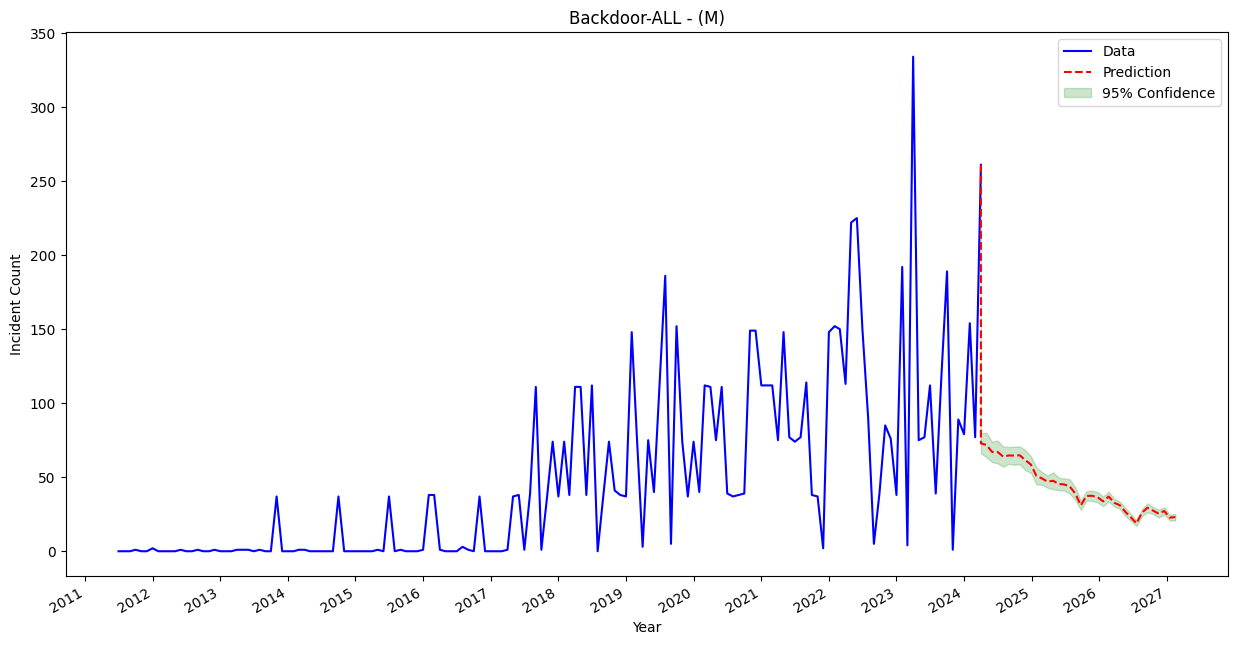

Forecast plot for Backdoor-ALL with seed None saved to Forecast_plot_Multivariate/Backdoor-ALL_forecast.png.


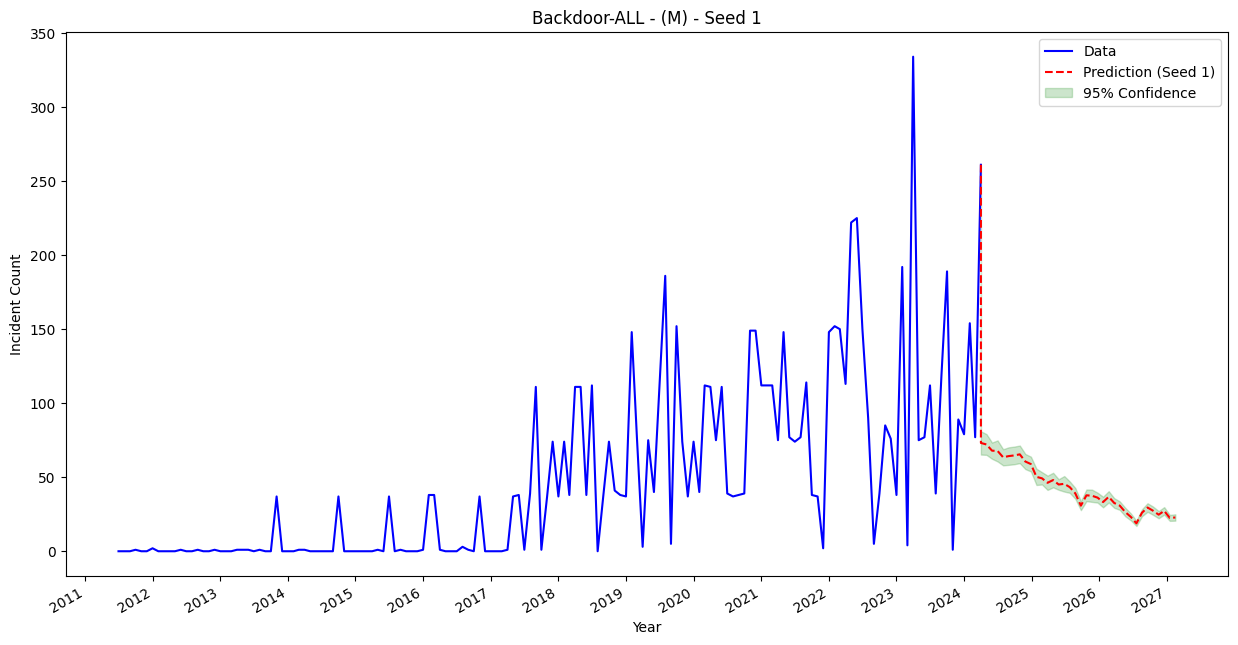

Forecast plot for Backdoor-ALL with seed 1 saved to Forecast_plot_Multivariate/Backdoor-ALL_forecast_seed_1.png.


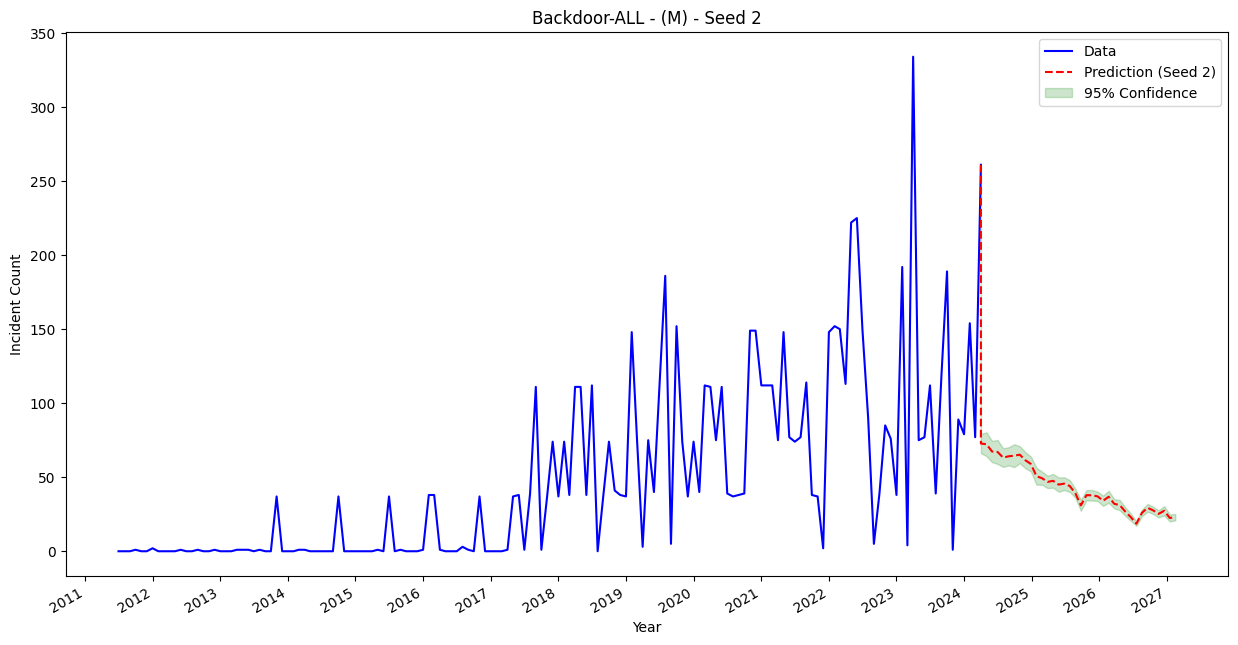

Forecast plot for Backdoor-ALL with seed 2 saved to Forecast_plot_Multivariate/Backdoor-ALL_forecast_seed_2.png.


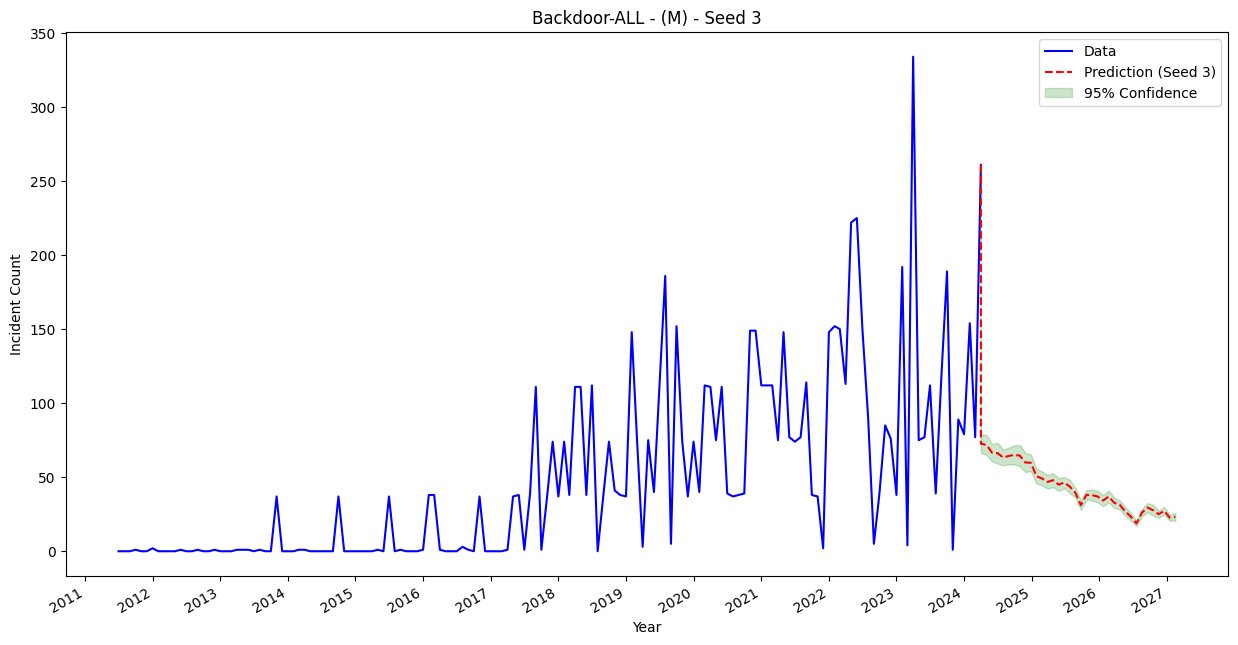

Forecast plot for Backdoor-ALL with seed 3 saved to Forecast_plot_Multivariate/Backdoor-ALL_forecast_seed_3.png.


In [37]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import timedelta
import json
import os
import matplotlib.dates as mdates

# seed_number = 42
# np.random.seed(seed_number)
# tf.random.set_seed(seed_number)
# random.seed(seed_number)

# Exponential Smoothing
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return np.array(result)

# Double Exponential Smoothing
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return np.array(result)

# Prepare multivariate data for LSTM input
def prepare_multivariate_data(data, n_input, n_features):
    X, y = [], []
    for i in range(len(data) - n_input):
        X.append(data[i:(i + n_input), :])
        y.append(data[i + n_input, -1])
    return np.array(X), np.array(y)

# Build the LSTM Model with Monte Carlo Dropout
def build_mc_dropout_model(n_input, n_features, layer, unit, dropout_rate):
    model = Sequential()
    model.add(Input(shape=(n_input, n_features)))
    model.add(LSTM(unit[0], activation='relu', return_sequences=(layer > 1)))
    model.add(Dropout(dropout_rate))
    
    for i in range(1, layer):
        model.add(LSTM(unit[min(i, len(unit)-1)], activation='relu', return_sequences=(i < layer-1)))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mse')
    return model

# Monte Carlo Dropout prediction function
def mc_dropout_predict(model, X, n_iter=50):
    predictions = np.array([model(X, training=True) for _ in range(n_iter)])
    return predictions.mean(axis=0), predictions.std(axis=0)

# Function to generate future dates
def generate_future_dates(start_date, periods):
    return [start_date + timedelta(days=i*30) for i in range(periods)]  # Assuming monthly data

# Function to run seed-based forecasting and plot results
def run_seed_forecasting(target_variable, selected_data, scaler, model, forecast_horizon, data, last_date, output_plot_dir, seed=None):
    if seed is not None:
        np.random.seed(seed)
        tf.random.set_seed(seed)

    # Prepare for forecast generation
    last_sequence = selected_data[-model.input_shape[1]:]
    forecasts, lower_bounds, upper_bounds = [], [], []
    
    for _ in range(forecast_horizon):
        next_prediction_mean, next_prediction_std = mc_dropout_predict(model, last_sequence.reshape(1, model.input_shape[1], model.input_shape[2]))
        forecasts.append(next_prediction_mean[0, 0])
        
        lower_bound_scaled = next_prediction_mean[0, 0] - 1.96 * next_prediction_std[0, 0]
        upper_bound_scaled = next_prediction_mean[0, 0] + 1.96 * next_prediction_std[0, 0]
        
        lower_bounds.append(lower_bound_scaled)
        upper_bounds.append(upper_bound_scaled)
        
        last_sequence = np.roll(last_sequence, -1, axis=0)
        last_sequence[-1, -1] = next_prediction_mean[0, 0]
    
    # Inverse transform the forecasts and confidence intervals
    dummy_array = np.zeros((len(forecasts), model.input_shape[2]))
    dummy_array[:, -1] = forecasts
    forecasts_inv = scaler.inverse_transform(dummy_array)[:, -1]
    
    dummy_array[:, -1] = lower_bounds
    lower_bounds_inv = scaler.inverse_transform(dummy_array)[:, -1]
    
    dummy_array[:, -1] = upper_bounds
    upper_bounds_inv = scaler.inverse_transform(dummy_array)[:, -1]
    
    # Generate future dates for the forecast
    future_dates = generate_future_dates(last_date, forecast_horizon)
    future_dates = [last_date] + future_dates
    
    # Append the last historical data point to the beginning of the forecast for a seamless plot
    seamless_forecast = np.insert(forecasts_inv, 0, data[target_variable].iloc[-1])
    lower_bounds_inv = np.insert(lower_bounds_inv, 0, data[target_variable].iloc[-1])
    upper_bounds_inv = np.insert(upper_bounds_inv, 0, data[target_variable].iloc[-1])
    
    # Plot the historical data and forecast
    plt.figure(figsize=(15, 8))
    plt.plot(data.index, data[target_variable], label='Data', color='blue', linestyle='-')
    plt.plot(future_dates, seamless_forecast, label=f'Prediction (Seed {seed})' if seed is not None else 'Prediction', color='red', linestyle='--')
    plt.fill_between(future_dates, lower_bounds_inv, upper_bounds_inv, color='green', alpha=0.2, label='95% Confidence')
    
    plt.title(f'{target_variable} - (M) - Seed {seed}' if seed is not None else f'{target_variable} - (M)')
    plt.xlabel('Year')
    plt.ylabel('Incident Count')
    plt.legend()
    
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # Improve x-axis readability
    plt.gcf().autofmt_xdate()
    
    # Save the plot
    plot_name = f'{target_variable}_forecast_seed_{seed}.png' if seed is not None else f'{target_variable}_forecast.png'
    plot_path = os.path.join(output_plot_dir, plot_name)
    plt.savefig(plot_path)
    plt.show()
    
    print(f"Forecast plot for {target_variable} with seed {seed} saved to {plot_path}.")

# Main execution
if __name__ == "__main__":
    # Load and preprocess data
    data = pd.read_csv('FinalDataset.csv')
    data['Date'] = pd.to_datetime(data['Date'], format='%b-%y')
    data.set_index('Date', inplace=True)
    

    target_variable = 'Backdoor-ALL'
    features = ['Mentions-Backdoor', 'WAR/CONFLICT MY', 'Twitter Users (M)', 'Backdoor-ALL']



    selected_data = data[features].values
    
    # Load best parameters
    with open(f'best_params_files_25M/{target_variable}_best_params.json', 'r') as f:
        best_params = json.load(f)['Best Parameters']

    # Apply smoothing to the target variable
    if best_params['smoothing_method'] == 'exponential':
        selected_data[:, -1] = exponential_smoothing(selected_data[:, -1], best_params['alpha'])
    elif best_params['smoothing_method'] == 'double_exponential':
        selected_data[:, -1] = double_exponential_smoothing(selected_data[:, -1], best_params['alpha'], best_params['beta'])
    
    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(selected_data)
    
    # Prepare data for LSTM
    n_input = best_params['n_input']
    n_features = len(features)
    X, y = prepare_multivariate_data(scaled_data, n_input, n_features)

    # Train on Full Data - n_input
    X_train = X[:-n_input]  # Slice to exclude the last n_input
    y_train = y[:-n_input]  # Slice to exclude the last n_input
    
    # Build and train the model on the complete dataset
    model = build_mc_dropout_model(n_input, n_features, best_params['layer'], best_params['units'], best_params['dropout_rate'])
    model.fit(X_train, y_train, epochs=best_params['n_epochs'], batch_size=32, verbose=0)
    
    # Generate forecast for the next 3 years (36 months)
    forecast_horizon = 36
    last_date = data.index[-1]
    
    output_plot_dir = 'Forecast_plot_Multivariate'
    os.makedirs(output_plot_dir, exist_ok=True)
    
    # Run original forecast (no seed)
    run_seed_forecasting(target_variable, scaled_data, scaler, model, forecast_horizon, data, last_date, output_plot_dir)
    
    # Run seed-based forecasting
    for seed in [1, 2, 3]:
        run_seed_forecasting(target_variable, scaled_data, scaler, model, forecast_horizon, data, last_date, output_plot_dir, seed=seed)
